# Titanic: Machine Learning From Disaster (Kaggle challenge)
- [Import, Split and Light Cleaning](#ImportSplit)
    - import and immediately split data into respective training and testing data sets 
    - breakup complex features to more simplified version for exploratory anaysis 
- [Exploratory Analysis](#ExpAn) 
    - look at how passenger survival differs for each feture
    - look at the impact class and gender has on passenger survival when taking into account the other features as well 
    - summarize general conclusions based on initial analysis 
- [Feature engineering](#FeatEng) 
    - based on exploratory analysis, clean up target features 
    - create interactive features based on class and genders impact on other features  
- [Building and evaluating models](#buildEval) 
    - create list variables to group target variables in different variations for multi model execution
    - use custom build function to build either logistic regression, decision tree or random forest models and simultaneously create their respective ROC/Precision-recall curves  
- [Hyperparameter Optimization](#hypOpt)
    - conduct a grid search to determine which parameters to use to improve random forest model 
- [Test model with test data split (from earlier split, not kaggle test.csv)](#acc)
    - calculate the model accuracy score when implement test dependent and independent features 

<a id='ImportSplit'></a>
# Import Data and Split into sets

In [1]:
#import data 
import pandas as pd
import warnings 
warnings.simplefilter('ignore')
df=pd.read_csv('train.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#what data types are in each feature 
types=pd.DataFrame(df.dtypes)
Nas=pd.DataFrame(df.isna().sum())
infoTable=pd.concat({'Feature Type':types, 'NaNs':Nas}, axis=1)
display(infoTable)

,Feature Type,NaNs
,0,0
Survived,int64,0
Pclass,int64,0
Name,object,0
Sex,object,0
Age,float64,177
SibSp,int64,0
Parch,int64,0
Ticket,object,0
Fare,float64,0


**Splitting df into repsective training and testing data sets**

In [3]:
# Split Data Frame into Train and Test Sets 
##select dependent and independent variables 
y=df['Survived']
X=df.iloc[:, 1:]
##split the df into training and testing data sets 
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest=train_test_split(X, y, test_size=0.2, random_state=88, stratify=y)
print('data frame prior to split: ', df.shape)
print('test set feature dimensions: ', xTest.shape)
print('test set outcome dimension:' , yTest.shape)

data frame prior to split:  (891, 11)
test set feature dimensions:  (179, 10)
test set outcome dimension: (179,)


**Modify some features of interst for exploratory analysis**

In [4]:
def xCleaner(X):
    '''clean up the x df for exploratory analysis and model building'''
    #change name columm so only show passengers title  
    X['Name']=X['Name'].str.split(pat=', |\.') 
    for i in range(len(X)):
        X['Name'].iloc[i]=X['Name'].iloc[i][1]
    X['Name']=X.Name.apply(str)

    ##numerically fill in Age NaNs with feature mean and bin them into seperate columns
    X['Age'].fillna((X['Age'].mean()), inplace=True)
    bins=pd.cut(X['Age'], bins=[1,6,13,20,51,100],
                labels=['toddler', 'adolescent', 'teen', 'adult', 'elderly']) 
    bin2=pd.get_dummies(bins)
    X=pd.concat([X, bin2], axis=1)
    
    ##one-hot encoding to seperate each category of each column into its own column
    oneHot=pd.get_dummies(X['Name'])
    X=pd.concat([X, oneHot], axis=1)
    oneHot=pd.get_dummies(X['SibSp'], prefix='SS')
    X=pd.concat([X, oneHot], axis=1)
    oneHot=pd.get_dummies(X['Parch'], prefix='PC')
    X=pd.concat([X, oneHot], axis=1)
    oneHot=pd.get_dummies(X['Sex'])
    X=pd.concat([X, oneHot], axis=1) 
    oneHot=pd.get_dummies(X['Pclass'], prefix='Class')
    X=pd.concat([X, oneHot], axis=1)
    oneHot=pd.get_dummies(X['Embarked'])
    X=pd.concat([X, oneHot], axis=1)
    
    #to return the df modification the function made
    return(X)

In [5]:
#assign the modification the function made to a global variable 
xTrain=xCleaner(xTrain)

In [6]:
#verify all is good with columns
xTrain.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'toddler', 'adolescent', 'teen', 'adult',
       'elderly', 'Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'the Countess', 'SS_0',
       'SS_1', 'SS_2', 'SS_3', 'SS_4', 'SS_5', 'SS_8', 'PC_0', 'PC_1', 'PC_2',
       'PC_3', 'PC_4', 'PC_5', 'PC_6', 'female', 'male', 'Class_1', 'Class_2',
       'Class_3', 'C', 'Q', 'S'],
      dtype='object')

<a id='ExpAn'></a>
## Exploratory analysis 

In [7]:
#merge training data together for analysis 
dfTrain=pd.concat([yTrain, xTrain], axis=1)

In [8]:
#take a look at what columns the df has 
dfTrain.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'toddler', 'adolescent', 'teen', 'adult',
       'elderly', 'Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'the Countess', 'SS_0',
       'SS_1', 'SS_2', 'SS_3', 'SS_4', 'SS_5', 'SS_8', 'PC_0', 'PC_1', 'PC_2',
       'PC_3', 'PC_4', 'PC_5', 'PC_6', 'female', 'male', 'Class_1', 'Class_2',
       'Class_3', 'C', 'Q', 'S'],
      dtype='object')

**Examine Each features impact on passenger survival**

In [9]:
#import necessary graphing libraries 
import matplotlib.pyplot as plt
import seaborn as sns

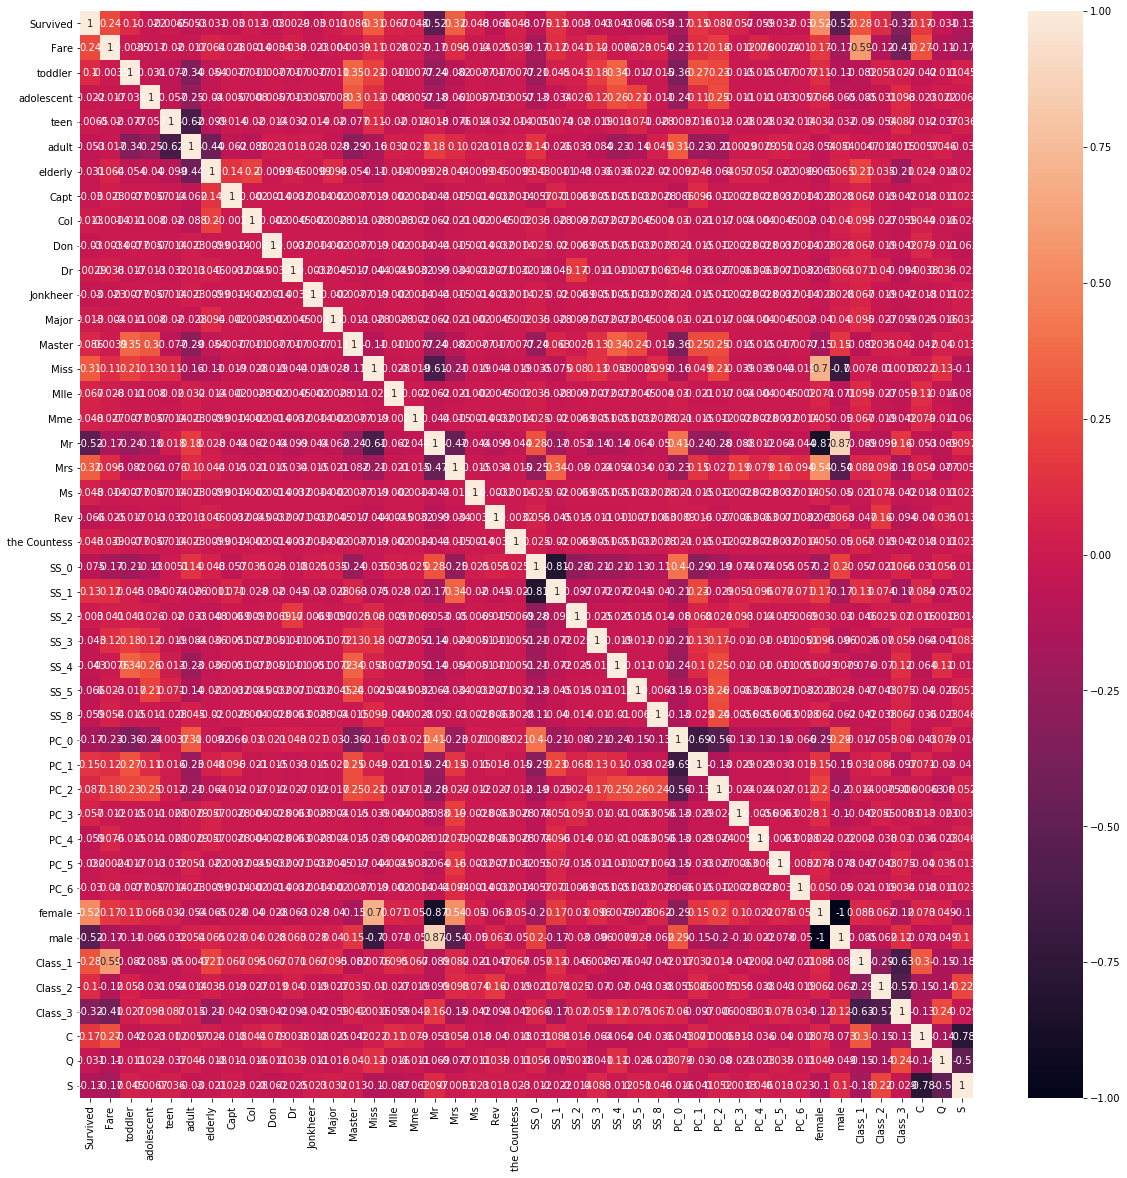

In [10]:
#create a correlation data frame to take out repertitive column info 
dfCorr=dfTrain.drop(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch'], axis=1)
#create correlation heat map 
corr=dfCorr.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)

In [11]:
#massive heat map with over whelming info, take a look at the top correlations 
dfCorr.corr().unstack().sort_values(ascending=False).drop_duplicates().head(15)

S         S          1.000000
Mr        male       0.872714
female    Miss       0.696663
Fare      Class_1    0.586752
female    Mrs        0.536469
Survived  female     0.516225
PC_0      Mr         0.411341
          SS_0       0.401277
toddler   Master     0.352956
          SS_4       0.343399
Master    SS_4       0.343399
SS_1      Mrs        0.340295
Survived  Mrs        0.322161
PC_0      adult      0.311966
Survived  Miss       0.311645
dtype: float64

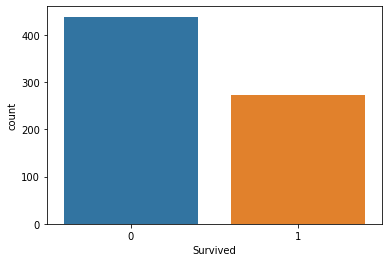

In [12]:
#take a look at the absolute survival count 
sns.countplot(dfTrain['Survived'])

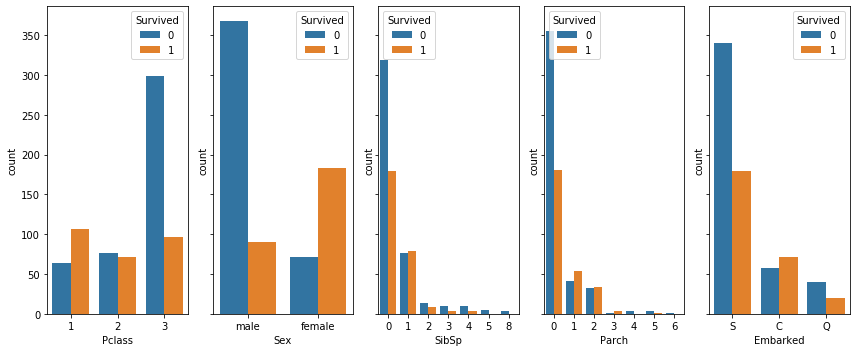

In [13]:
#look at survival for multiple categories 
fig, g=plt.subplots(1,5, figsize=(12,5), sharey=True)
sns.countplot(x='Pclass', hue='Survived', data=dfTrain, ax=g[0])
sns.countplot(x='Sex', hue='Survived', data=dfTrain, ax=g[1])
sns.countplot(x='SibSp', hue='Survived', data=dfTrain, ax=g[2])
sns.countplot(x='Parch', hue='Survived', data=dfTrain, ax=g[3])
sns.countplot(x='Embarked', hue='Survived', data=dfTrain, ax=g[4])
plt.tight_layout()

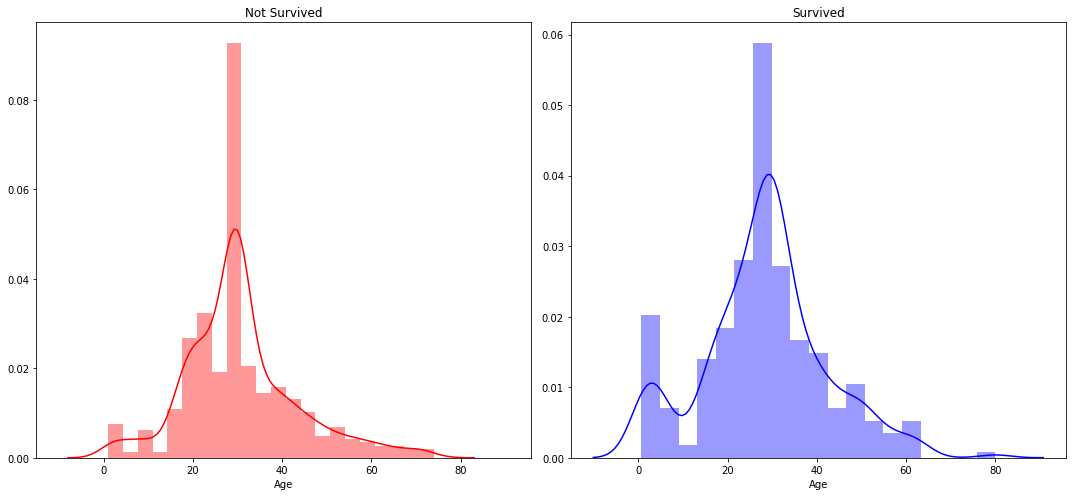

In [14]:
#take a look at the age distribution for survived vs not 
fig, g= plt.subplots(1, 2, figsize=(15,7), sharex=True)
sns.distplot(dfTrain[dfTrain['Survived']==0]['Age'], color='r', ax=g[0]).set(title='Not Survived')
sns.distplot(dfTrain[dfTrain['Survived']==1]['Age'], color='b', ax=g[1]).set(title='Survived')
plt.tight_layout()

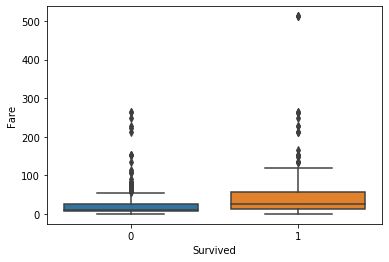

In [15]:
#take a look at fare comparing survived to those who didn't 
sns.boxplot(x='Survived', y='Fare', data=dfTrain)

**take a look at interacting variables**

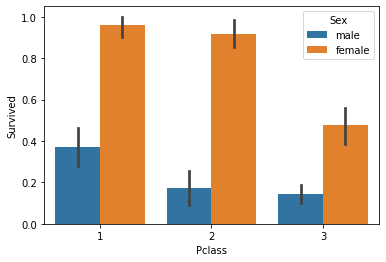

In [16]:
#take a look at the gender survival rate per class
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=dfTrain)

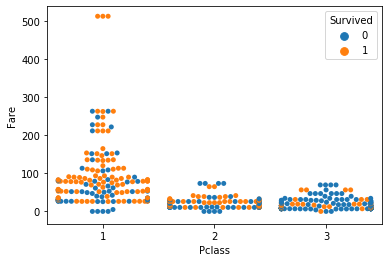

In [17]:
#taking a look at how price fare for each class correlated with passenger survival 
sns.swarmplot(x='Pclass', y='Fare', hue='Survived', data=dfTrain)

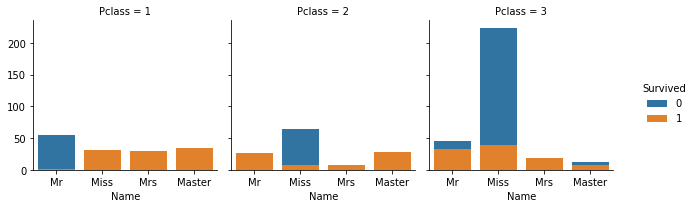

In [18]:
#taking a look at survival of passengers in ecah class based on title 
g=sns.FacetGrid(dfTrain, col='Pclass', hue='Survived', margin_titles=True)
g.map(sns.countplot, 'Name').add_legend()

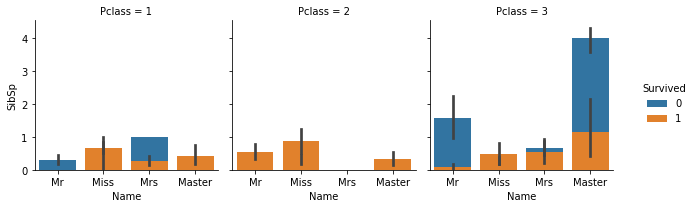

In [19]:
#taking a look at how SibSp with Name per class affected survival 
g=sns.FacetGrid(dfTrain, col='Pclass', hue='Survived', margin_titles=True)
g.map(sns.barplot, 'Name', 'SibSp').add_legend()

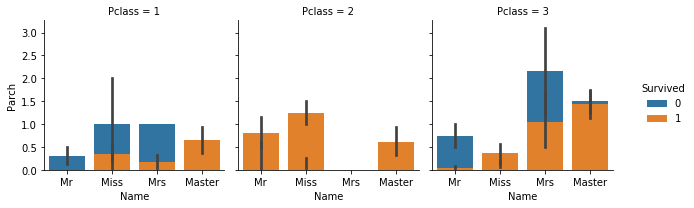

In [20]:
#taking a look at how Parch with Name per class affected survival 
g=sns.FacetGrid(dfTrain, col='Pclass', hue='Survived', margin_titles=True)
g.map(sns.barplot, 'Name', 'Parch').add_legend()

<a id='FeatEng'></a>
## Feature Engineering

**Cleanup Test Data**

In [21]:
xTest=xCleaner(xTest)

**Creating Interactive Variables for both train and test data**

In [22]:
def interactVar(X):
    X['MrSibSpPclass']=X['Mr']*X['SibSp']*X['Pclass']
    X['MrsParchPclass']=X['Mrs']*X['Parch']*X['Pclass']
    X['MissPclass']=X['Miss']*X['Pclass']
    X['FarePclass']=X['Fare']*X['Pclass']
    X['FemalePclass']=X['female']*X['Pclass']
    return(X)

In [23]:
xTrain=interactVar(xTrain)
xTest=interactVar(xTest)

In [24]:
xTrain.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'toddler', 'adolescent', 'teen', 'adult',
       'elderly', 'Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'the Countess', 'SS_0',
       'SS_1', 'SS_2', 'SS_3', 'SS_4', 'SS_5', 'SS_8', 'PC_0', 'PC_1', 'PC_2',
       'PC_3', 'PC_4', 'PC_5', 'PC_6', 'female', 'male', 'Class_1', 'Class_2',
       'Class_3', 'C', 'Q', 'S', 'MrSibSpPclass', 'MrsParchPclass',
       'MissPclass', 'FarePclass', 'FemalePclass'],
      dtype='object')

In [25]:
xTest.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'toddler', 'adolescent', 'teen', 'adult',
       'elderly', 'Dr', 'Lady', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev', 'Sir',
       'SS_0', 'SS_1', 'SS_2', 'SS_3', 'SS_4', 'SS_8', 'PC_0', 'PC_1', 'PC_2',
       'PC_3', 'female', 'male', 'Class_1', 'Class_2', 'Class_3', 'C', 'Q',
       'S', 'MrSibSpPclass', 'MrsParchPclass', 'MissPclass', 'FarePclass',
       'FemalePclass'],
      dtype='object')

<a id='buildEval'></a>
### Building and evaluating models 
- code for ROC and precision-recall curves based on this [blog post](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [26]:
#categorizing features into different list 
basic=['Pclass', 'Age', 'SibSp', 'Parch']
classB=['MissPclass', 'FarePclass', 'FemalePclass']
companionB=['MrSibSpPclass', 'MrsParchPclass']
moneyB=['Pclass', 'S', 'Q', 'C', 'Fare']
femaleFamB=['Miss', 'Mrs', 'toddler', 'adolescent', 'Class_3']
maleFamB=['Mr','Master', 'toddler', 'adolescent','Class_3', 'Class_1']
#grouping lists into models 
xIndex=[basic, classB, companionB, moneyB, femaleFamB, maleFamB]
modName=['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6']

In [27]:
#import libraries for function 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.dummy import DummyClassifier

def modPlots(xIndex, modName, yTest, modType):
    xTest1=xTest
    y=yTrain
    yTest=yTest
    accScore=[]
    aucScore1=[] ##AUC for ROC curves 
    precScore=[]
    recallScore=[]
    f1Score=[] 
    aucScore2=[] ##AUC for prec-recall curves  
    
    #initiate the ROC and precision-recall graphs that will be supplemented by the fo loop 
    fig, (g1, g2)=plt.subplots(1,2, figsize=(15,8))
    nsProbs=[0 for num in range(len(yTest))] ##create variable for random chance line for ROC graph 
    nsFP, nsTP, _=roc_curve(yTest, nsProbs) ##calc this random chance line based on variable 
    g1.plot(nsFP, nsTP, linestyle='--', label='No Skill') ##add random chance curve to ROC subplot 
    nsProbs2=len(yTest[yTest==1])/len(yTest) ##create random chance curve for precision-recall sub graph
    g2.plot([0,1], [nsProbs2, nsProbs2], linestyle='--', label='No Skill') ##add random chance curve to precision-recall sub graph

    ##regenrate needed models 
    for i in range(len(xIndex)):
        ##initiate and fit a model 
        if modType == 'logReg':
            m=LogisticRegression()
        elif modType == 'dt':    
            m=DecisionTreeClassifier()
        elif modType == 'rf':
            m=RandomForestClassifier()
        X=xTrain[xIndex[i]]
        xTest1=xTest[xIndex[i]]
        m.fit(X, y)
        ##calculate model accuracy 
        yPredm=m.predict(X)
        accVal=accuracy_score(y, yPredm)
        accScore.append(accVal)
        ##predict probabilities and keep only positive outcomes (1)
        mProbs=m.predict_proba(xTest1)[:, 1]
        #calculate ROC AUC and store for table 
        mAUC1=roc_auc_score(yTest, mProbs)
        aucScore1.append(mAUC1)
        ##calculate model components for ROC curve
        mFP, mTP, _=roc_curve(yTest, mProbs)
    
        ##graph ROC curve for every model onto the first subplot
        g1.plot(mFP, mTP, linestyle=':', label=modName[i])    
        g1.set_xlabel('False Positive Rate')
        g1.set_ylabel('True Positive Rate')
        g1.set_title('Reciever Operating Characteristic (ROC) Curve')
        g1.legend()
    
        #collecting values for precision-recall curve
        mPrecision, mRecall, _=precision_recall_curve(yTest, mProbs)
        yhat=m.predict(xTest1)
        precVal=precision_score(y, yPredm) ##value for table 
        recVal=recall_score(y, yPredm) ##value for table 
        mF1=f1_score(yTest, yhat) ##for value table below
        mAUC2=auc(mRecall, mPrecision) ##for value table below 
        precScore.append(precVal)
        recallScore.append(recVal)
        f1Score.append(mF1)
        aucScore2.append(mAUC2)
        
        #build precision-recall curves
        g2.plot(mRecall, mPrecision, marker='.', label=modName[i])
        g2.set_xlabel('Recall')
        g2.set_ylabel('Precision')
        g2.set_title('Precision-Recall (PR) Curve')
        g2.legend() 
    plt.savefig('ROC' + str(modType) + '.png')
    plt.show() 
    
    #save AUC values into table 
    nsAUC=roc_auc_score(yTest, nsProbs) ##calculate AUC score
    aucScore1.append(nsAUC)
    accScore.append('NA')
    precScore.append('NA')
    recallScore.append('NA')
    f1Score.append('NA')
    aucScore2.append('NA')
    modName.append('no skill')
    aucTable=pd.DataFrame({'Model Accuracy': accScore,'AUC for ROC':aucScore1, 
                           'Precision core':precScore, 'Recall score':recallScore,
                           'F1 score': f1Score, 'AUC for PR curve': aucScore2}, index=modName)
    #modName.remove('no skill') ##to remove string for next function
    display(aucTable)

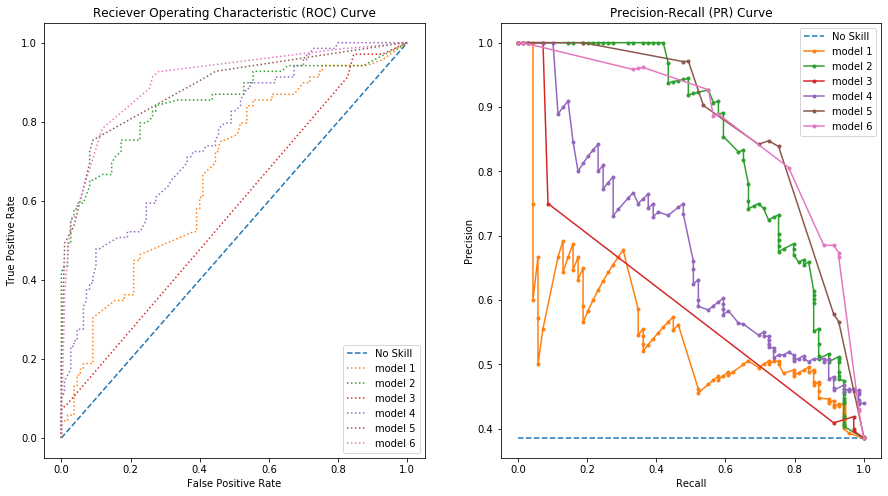

,Model Accuracy,AUC for ROC,Precision core,Recall score,F1 score,AUC for PR curve
model 1,0.858146,0.670685,0.873913,0.736264,0.486486,0.552949
model 2,0.908708,0.848946,0.88806,0.871795,0.727273,0.841368
model 3,0.651685,0.574242,0.804878,0.120879,0.155844,0.599227
model 4,0.823034,0.757115,0.788235,0.736264,0.567164,0.680225
model 5,0.782303,0.884387,0.827778,0.545788,0.672727,0.872571
model 6,0.785112,0.901318,0.715827,0.728938,0.794118,0.873392
no skill,NA,0.500000,NA,NA,NA,NA


In [28]:
##for modType: 'logReg' for LogisticRegression(), 
##'dt' for DecisionTreeClassifier() 
##'rt' for RandomForestClassifier
modPlots(xIndex, modName, yTest, 'rf')

<a id='hypOpt'></a>
## Hyperparameter Optimization

In [29]:
#attempt to optimize randomforest

##build model 
from sklearn.ensemble import RandomForestClassifier
X=xTrain[maleFamB]
y=yTrain
m=RandomForestClassifier()
m.fit(X,y)

#run grid search 
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [20, 50, 100, 250, 500],'max_depth': [1, 3, 5, 10, None]}
gridcv = GridSearchCV(m, param_grid=param_grid)
gridcv.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [30]:
#take a closer look at optimal parameters
gridcv.best_estimator_
results = pd.DataFrame(gridcv.cv_results_)
columns = ['mean_test_score', 'std_test_score', 'mean_fit_time', 'param_max_depth','param_n_estimators']
results[columns].sort_values('mean_test_score', ascending=False).head()

,mean_test_score,std_test_score,mean_fit_time,param_max_depth,param_n_estimators
3,0.783690,0.031694,0.454202,1,250
4,0.783690,0.031694,0.899768,1,500
7,0.782291,0.033094,0.196191,3,100
8,0.780882,0.034412,0.462619,3,250
9,0.779474,0.036451,0.863699,3,500


<a id='acc'></a>
## Accuracy with test data 

In [31]:
##build model 
from sklearn.ensemble import RandomForestClassifier
X=xTrain[maleFamB]
y=yTrain
m=RandomForestClassifier(max_depth=1, n_estimators=500)
m.fit(X,y)

xTest1=xTest[maleFamB]

print('training score: ', m.score(X, y).round(3))
print('test score: ', m.score(xTest1, yTest).round(3))

training score:  0.784
test score:  0.81
